# testing

In [1]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("fever/fever",'v1.0')

c:\Users\phoni\anaconda3\envs\NLP_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\phoni\anaconda3\envs\NLP_env\lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for fever/fever contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fever/fever
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## data collection

### FEVER

In [2]:
label_type_ls = list(set(dataset['train']['label']))

label_type_ls

['REFUTES', 'SUPPORTS', 'NOT ENOUGH INFO']

### LIAR

In [3]:
def read_dataframe(tsv_file:str)->pd.DataFrame:
    """read lair dataset and convert to dataframe 

    Args:
        tsv_file (string): tsv file path

    Returns:
        dataframe: dataframe of the lair dataset
    """
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)
    df.fillna("", inplace=True)
    df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.

        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.

        'context' # Column 14: the context (venue / location of the speech or statement).
    ]
    return df

In [4]:
fp = 'liar_ds/'
train_df = read_dataframe(f'{fp}/train.tsv')
test_df = read_dataframe(f'{fp}/test.tsv')
val_df = read_dataframe(f'{fp}/valid.tsv')

In [5]:
train_df.head(3)

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release


## Analysing the dataset 

In [6]:

import seaborn as sns
import matplotlib.pyplot as plt

def label_bar_chart(input_df: pd.DataFrame, title: str = "LIAR Dataset") -> None:
    """plot lair dataset as bar chart 

    Args:
        input_df (pd.DataFrame): _description_
        title (str, optional): _description_. Defaults to "LIAR Dataset".

    Returns:
        _type_: _description_
    """
    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df['label'].value_counts(normalize=True)
    
    def multiply_100(x):
        return x * 100
    
    # "apply" is a handy way to call a function on every row of data.
    label_frequencies = label_frequencies.apply(multiply_100)
    
    # bar chart ordering and  colors for readability.
    labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
    colors = [
        'orangered', # pants-fire
        'coral', # false
        'salmon', # barely-true
        'peachpuff', # half-true
        'skyblue', # mostly-true
        'deepskyblue' # true
    ]
    
    label_frequencies = label_frequencies.reindex(index = labels)
    
    
    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(4, 2), color=colors)
    axis.set_title(f"distribution of label values ({title}, sample_size={len(input_df)})", size=20);

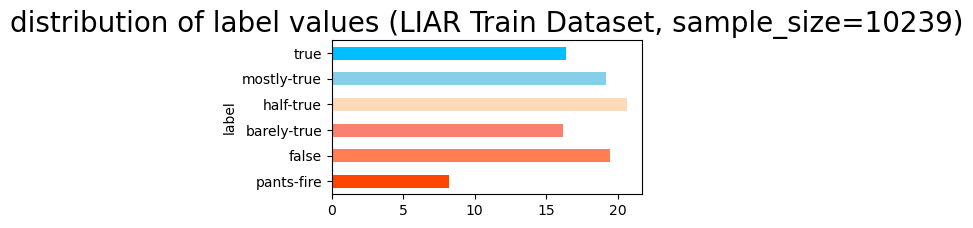

In [7]:
label_bar_chart(train_df, "LIAR Train Dataset")

### Speaker analysis 

In [8]:
unique_speaker_ls = train_df['speaker'].value_counts().index.tolist()


avg_statements_per_speaker = train_df['speaker'].value_counts().mean()

print(f"average statements per speaker: {avg_statements_per_speaker}")
unique_speaker_ls[:5], len(unique_speaker_ls)

average statements per speaker: 3.5185567010309278


(['barack-obama',
  'donald-trump',
  'hillary-clinton',
  'mitt-romney',
  'scott-walker'],
 2910)

In [9]:
def speaker_bar_plot(df:pd.DataFrame, speaker: str)-> pd.DataFrame:
    """plot speaker bar chart 

    Args:
        df (pd.DataFrame): dataframe
        speaker (str): speaker

    Returns:
        pd.DataFrame: dataframe
    """
    speaker_df = df[df['speaker'] == speaker]
    label_bar_chart(speaker_df, f"LIAR {speaker} Dataset")
    return speaker_df

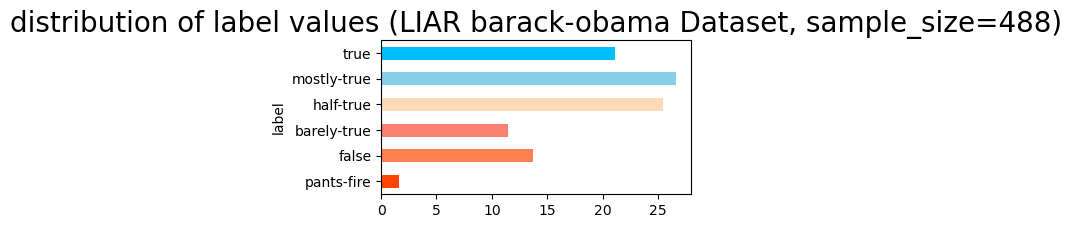

In [10]:
ret_df = speaker_bar_plot(train_df, 'barack-obama')

### Subject analysis

In [11]:
subj_df = train_df[['label', 'subjects']].copy()

def csv2ls(csv_str:str)->list:
    """convert csv string to list 

    Args:
        csv_str (str): csv string

    Returns:
        list: list
    """
    return csv_str.split(',')

subj_df['subjects'] = subj_df['subjects'].apply(csv2ls)
#convert col into row
subj_df = subj_df.explode('subjects')
subj_df.head()


,label,subjects
0,half-true,energy
0,half-true,history
0,half-true,job-accomplishments
1,mostly-true,foreign-policy
2,false,health-care


In [12]:
unique_subjects_ls = subj_df['subjects'].value_counts().index.tolist()
unique_subjects_ls[:5], len(unique_subjects_ls)

(['economy', 'health-care', 'taxes', 'federal-budget', 'education'], 143)

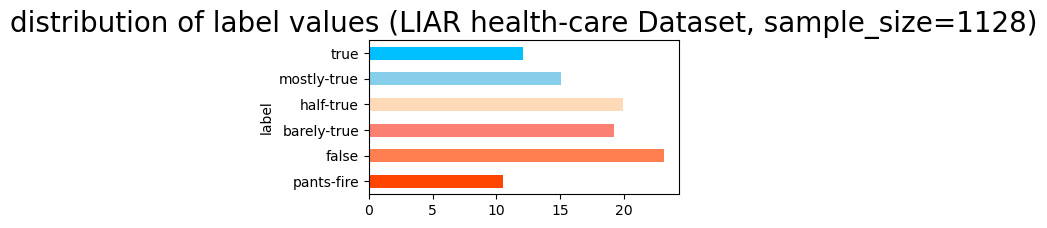

In [13]:
def subj_bar_plot(df:pd.DataFrame, subject: str)-> pd.DataFrame:
    """plot subject bar chart 

    Args:
        df (pd.DataFrame): dataframe
        subject (str): subject

    Returns:
        pd.DataFrame: dataframe
    """
    subj_df = df[df['subjects'] == subject]
    label_bar_chart(subj_df, f"LIAR {subject} Dataset")
    return subj_df

ret_df = subj_bar_plot(subj_df, 'health-care')

In [14]:
from typing import Dict

def score_label(label:str)-> float:
    """score label 

    Args:
        label (str): label

    Returns:
        float: score
    """
    label_score = {
        'true': 2,
        'mostly-true': 1,
        'half-true': 0,
        'barely-true': -1,
        'false': -2,
        'pants-fire': -3
    } 
    return label_score[label]

def model_speaker_statements(input_df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    
    tot = {}
    count = {}
    
    # for each row in the input_df
    for _, row in input_df.T.items():
        
        # grab the pertinent information
        speaker = row['speaker']
        score = score_label(row['label'])
        words = row['statement'].lower().split()
        
        # prevents double counting of words
        uniques = []
        
        for word in words:
            # if its a word we've already seen, skip processing
            if word in uniques:
                continue
                    
            uniques.append(word)
            
            if speaker in tot:
                if word in tot[speaker]:
                    tot[speaker][word] += score
                    count[speaker][word] += 1
                else:
                    tot[speaker][word] = score
                    count[speaker][word] = 1
                    
            else:
                tot[speaker] = {}
                tot[speaker][word] = score
                
                count[speaker] = {}
                count[speaker][word] = 1
                
    
    # compute averages and return model
    for speaker in tot:
        for word in tot[speaker]:
            tot[speaker][word] = tot[speaker][word] / count[speaker][word]
            
    return tot


def score_speaker_statement(model: Dict[str, Dict[str, float]], speaker: str, phrase: str) -> float:
        
    idx = 0
    score = 0
    for word in phrase.split():
        word = word.lower()
        
        if word in model[speaker]:
            score += model[speaker][word]
            idx += 1
            
    if not idx:
        return None
    
    return score / idx
       
def get_label_by_score(score):
    print(score)
    
    label_score_ranges = {
        'true': (2, float('inf')),       
        'mostly-true': (1, 2),           
        'half-true': (0, 1),             
        'barely-true': (-1, 0),          
        'false': (-2, -1),               
        'pants-fire': (float('-inf'), -2)
    }
    
    for key, (lower, upper) in label_score_ranges.items():
        if lower <= score < upper:
            return key
    return None  # Return None if the score does not match any range       


def sentiment_speaker_statement(model: Dict[str, Dict[str, float]], speaker: str, phrase: str) -> str:

    score = score_speaker_statement(model, speaker, phrase)
    print(get_label_by_score(score))

    
    if score is None:
        return None
    
    if score <= 0:
        return False
    
    return True



In [15]:
from IPython.display import Image

#build a model from the lair dataset 
model = model_speaker_statements(train_df)

In [16]:
speaker = 'joe-biden'
senti = f' Starting in 2025 "no matter what your total bills are for prescription drugs,” Medicare Part D users will never pay “more than $2,000 a year, because some of these cancer drugs are 10(,000 to) 15,000 bucks a year.” '

sentiment_speaker_statement(model, speaker, senti)

0.43943713450292393
half-true


True

In [17]:
speaker = 'donald-trump'
senti = "The unemployment rate for Wisconsin workers has reached historic lows. It’s never been this low before, ever, ever, ever."

sentiment_speaker_statement(model, speaker, senti)

-1.3078901385353
false


False

In [18]:
speaker = 'joe-biden'
senti = "Inflation was 20% when I came to office."

output = sentiment_speaker_statement(model, speaker, senti)
print(f'output: {output}')

-0.29861111111111116
barely-true
output: False


## RAG testing 

In [ ]:
import torch
from transformers import RagTokenizer, RagRetriever, RagSequenceForGeneration


tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-base")
retriver = RagRetriever.from_pretrained("facebook/rag-token-base", index_name="exact", use_dummy_dataset=True)
model = RagSequenceForGeneration.from_pretrained("facebook/rag-token-base", retriever=retriver)

In [81]:
import requests
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv('API_KEY')


In [78]:

def fetch_doc_from_newsapi(query:str, num_articles:int = 5)->list:
    url = f'https://newsapi.org/v2/everything?q={query}&apiKey={api_key}'
    response = requests.get(url)
    articles = response.json().get('articles', [])
    documents = [article['content'] for article in articles if article['content']]
    return documents


In [48]:
def process_statement_rag_with_newsapi(statements: list, labels: list)->list:
    res = []
    for sents, label in zip(statements, labels):
        # Fetch documents related to the statement from NewsAPI
        docs = fetch_doc_from_newsapi(sents)
        
        if not docs:
            res.append((["No relevant documents found"], label))
            continue
        
        # Tokenize the statement and documents
        inputs = tokenizer(sents, return_tensors="pt")
        doc_inputs = tokenizer(docs, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate prediction using retrieved documents
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            context_input_ids=doc_inputs["input_ids"],
            context_attention_mask=doc_inputs["attention_mask"],
            num_return_sequences=1
        )

        # Decode the output
        gen_txt = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        res.append((gen_txt[0], label))

    return res

In [31]:
ex_train_df = train_df.copy()

#remain only speaker, statement and label
ex_train_df = ex_train_df[['speaker', 'statement', 'label']]
ex_train_df = ex_train_df.sample(10)
ex_train_df


,speaker,statement,label
5908,sarah-palin,President Obamas proposal calls for serious cu...,true
4051,gun-owners-america,"The Baucus health care bill ""could be used to ...",false
613,bobby-scott,"Nearly 2,000 high schools - roughly 12 percent...",true
8171,republican-party-florida,Says Charlie Crist rode on a jet that belongs ...,true
9737,mahlon-mitchell,Under a law proposed by Wisconsin Gov. Scott W...,true
1929,americans-prosperity,A government panel that didn't include cancer ...,pants-fire
9582,jimmy-massie,"In Virginias Medicaid program, approximately 3...",barely-true
6264,steve-king,"Says Rep. Maxine Waters, D-Calif., only needs ...",half-true
3533,rand-paul,We now consume at the federal level 25 percent...,true
5071,rhode-island-center-freedom-and-prosperity,"Common welfare programs give income of $43,330...",barely-true


In [38]:
l = ex_train_df['statement'].tolist()
l[0]

'President Obamas proposal calls for serious cuts in our own long-term carbon emissions, but China and India will still be allowed to increase their emissions.'

In [41]:

r = fetch_doc_from_newsapi('President')
r

[]

In [42]:
result = process_statement_rag_with_newsapi(ex_train_df['statement'].tolist(), ex_train_df['label'].tolist())

In [29]:
df_res = pd.DataFrame(result, columns=['generated_text', 'label'])
df_res.head()



,generated_text,label
0,[No relevant documents found],false
1,[No relevant documents found],false
2,[No relevant documents found],half-true
3,offoffoffoffoffoffoffoffoffoffoffoffoffoffoffo...,true
4,[No relevant documents found],mostly-true


## Design

In [87]:
import spacy
from spacy.tokens import Span
nlp = spacy.load('en_core_web_trf')

In [9]:

def extract_entities(text):
  """extract entities from text using spacy and return a list of tuples containing the entity text and label

  Args:
      text (string): input text such as article or statement

  Returns:
      list: list of tuples containing the entity text and label
  """
  doc = nlp(text)
  return [(ent.text, ent.label_) for ent in doc.ents]

In [8]:
sample_text = "Apple is looking at buying U.K. startup for $1 billion"
entities = extract_entities(sample_text)
entities

[('Apple', 'ORG'), ('U.K.', 'GPE'), ('$1 billion', 'MONEY')]

## Evidence ranking and presentaion

In [15]:
%pip install rank_bm25

  Using cached rank_bm25-0.2.2-py3-none-any.whl.metadata (3.2 kB)
Using cached rank_bm25-0.2.2-py3-none-any.whl (8.6 kB)
Note: you may need to restart the kernel to use updated packages.


## Bias mitigation

In [ ]:
%pip install aif360

In [ ]:

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

dataset = BinaryLabelDataset(df=train_df, label_names=['label'], protected_attribute_names=['attribute'])
metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{'attribute': 1}], unprivileged_groups=[{'attribute': 0}])

%pip install textaugment
from textaugment import EDA

t = EDA()
augmented_sentence = t.synonym_replacement("The quick brown fox jumps over the lazy dog")

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

y_true = test_df['label']
y_pred = model.predict(test_df['text'])

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}, Precision: {precision}")